In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

RFM analysis is a customer behavior segmentation technique. Based on customers’ historical transactions, RFM analysis refers to the customers’ transactions including recency, frequency and purchase amount. Recency means how recently customers have made their purchases; Frequency means how often customers have made their purchases; Monetary meanbs how much money customers have paid for their purchases.RFM is used for customer segmentation. 

Data set is from UCI online sales data use K-means clustering

In [1]:
data_path = '/Users/Zhang/notebooks/Customer Segmentation/data/'

In [7]:
df = pd.read_csv(data_path + 'customer_data.csv', header= 0, encoding= 'unicode_escape') ### uft 8

In [14]:
## calculate recency

import datetime
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df['amount'] = df.Quantity*df.UnitPrice
df2=df.copy()

reference_date = df2.InvoiceDate.max() + datetime.timedelta(days = 1)
df2['days_from_last_purchase'] = (reference_date - df2.InvoiceDate).astype('timedelta64[D]')
lastpurchase_day = df2[['CustomerID','days_from_last_purchase']].groupby('CustomerID').min().reset_index()
lastpurchase_day.rename(columns={'days_from_last_purchase':'recency'}, inplace=True)

In [16]:
## Frequency
###Calculate number of orders purchased by each customer
freq = df2[['CustomerID','InvoiceNo']].groupby(['CustomerID','InvoiceNo']).count().reset_index().\
groupby(["CustomerID"]).count().reset_index()
freq.rename(columns = {'InvoiceNo':'frequency'}, inplace = True)

In [47]:
###Total amount of money spent per customer
money = df2[['CustomerID','amount']].groupby('CustomerID').sum().reset_index()
money.rename(columns = {'amount':'monetary'}, inplace = True) 

In [50]:
print(lastpurchase_day)

      CustomerID  recency
0        12346.0    326.0
1        12347.0      2.0
2        12348.0     75.0
3        12349.0     19.0
4        12350.0    310.0
...          ...      ...
4367     18280.0    278.0
4368     18281.0    181.0
4369     18282.0      8.0
4370     18283.0      4.0
4371     18287.0     43.0

[4372 rows x 2 columns]


In [63]:
rfm = lastpurchase_day.merge(freq, how = 'left', on = 'CustomerID').merge(money, how = 'left', on = 'CustomerID')

In [65]:
rfm.dtypes

CustomerID    float64
recency       float64
frequency       int64
monetary      float64
dtype: object

In [66]:
###Calculating quantile values
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.2, .25, .3, .35, .4, .5, .6, .7, .8, .9]).to_dict()
###Benchmark to give score for recency indicator
def r_score(r):
    if r < quintiles['recency'][.2]:
        return 3 
    elif r < quintiles['recency'][.8]:
        return 2
    else: 
        return 1
###Benchmark to give score for frequency & monetary indicator.   
def fm_score(f): 
    if f > quintiles['frequency'][.8]:
        return 3
    elif f > quintiles['frequency'][.2]: 
        return 2
    else: 
        return 1

In [67]:
rfm2 = rfm.copy()
rfm2['r_score'] = rfm2.recency.apply(lambda x: r_score(x))
rfm2['f_score'] = rfm2.frequency.apply(lambda x: fm_score(x))
rfm2['m_score'] = rfm2.monetary.apply(lambda x: fm_score(x))
rfm2['rfm'] = rfm2['r_score'].map(str)+rfm2['f_score'].map(str) + rfm2['m_score'].map(str)

In [70]:
###Loyal Customers, who are the champions of all the customers with highest score of RFM. 
rfm2_group1 = rfm2[rfm2['rfm']=='333']
rfm2_group1['label'] = 'champion'
###Customers who have the most potential to become the Champions. 
rfm2_group2 = rfm2[rfm2['rfm'].str.contains('332|331|323|313')] 
rfm2_group2['label] = 'potential1'
###Customers whose 'frequency score and monetary score are slightly lower than potential 1 group
rfm2_group3 = rfm2[rfm2['rfm'].str.contains('321|322|311|312')] 
rfm2_group3['label'] = 'potential2'
###Customers who used to pay a lot of money and come to the store frequently. They did not purchase recently. 
rfm2_group4 = rfm2[rfm2['rfm'].str.contains('233')]
rfm2_group4['label'] = 'needing_attention1'
###Customers who do not come to store often and not frequently make purchases.
rfm2_group5 = rfm2[rfm2['rfm'].str.contains('223|213|212|231|232|211|221|222')]
rfm2_group5['label'] = 'needing_attention2'
###Customers who haven't paid a visit to the store for a long time. However, once in a while, they do spend lot of money
rfm2_group6 = rfm2[rfm2['rfm'].str.contains('132|123|113|133')]
rfm2_group6['label'] = 'lost1'
###Customers who churn
rfm2_group7 = rfm2[rfm2['rfm'].str.contains('111|112|121|122|131')]
rfm2_group7['label'] = 'lost2'

In [72]:
rfm2_group1.count()

CustomerID    365
recency       365
frequency     365
monetary      365
r_score       365
f_score       365
m_score       365
rfm           365
label         365
dtype: int64

In [73]:
rfm2_group2.count()

CustomerID    436
recency       436
frequency     436
monetary      436
r_score       436
f_score       436
m_score       436
rfm           436
label         436
dtype: int64

In [74]:
rfm2_group3.count()

CustomerID    3
recency       3
frequency     3
monetary      3
r_score       3
f_score       3
m_score       3
rfm           3
label         3
dtype: int64

In [75]:
rfm2_group4.count()

CustomerID    357
recency       357
frequency     357
monetary      357
r_score       357
f_score       357
m_score       357
rfm           357
label         357
dtype: int64

In [76]:
rfm2_group5.count()

CustomerID    2336
recency       2336
frequency     2336
monetary      2336
r_score       2336
f_score       2336
m_score       2336
rfm           2336
label         2336
dtype: int64

In [77]:
rfm2_group6.count()

CustomerID    842
recency       842
frequency     842
monetary      842
r_score       842
f_score       842
m_score       842
rfm           842
label         842
dtype: int64

In [78]:
rfm2_group7.count()

CustomerID    33
recency       33
frequency     33
monetary      33
r_score       33
f_score       33
m_score       33
rfm           33
label         33
dtype: int64

Conclusion
Above is a simple analysis of RFM. However, RFM may be a lot more meaningful when combined with other deep dive analysis. I hope that this article may be a helpful source of reference for your future work.

## clustering analysis

In [80]:
rfmSegmentation = rfm

In [81]:
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [83]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])

In [84]:
quantiles = quantiles.to_dict()

In [86]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary'].apply(FMClass, args=('monetary',quantiles,))

In [89]:
## K-means clustering

from sklearn.cluster import KMeans
import numpy as np
import csv

print(type(rfm))
print(rfm.columns)
print(rfm['recency'][0])
KMeanTable = [[]]
for i in range(len(rfm)):
    kMeanLine = []
    kMeanLine.append(rfm['recency'][i])
    kMeanLine.append(rfm['monetary'][i])
    kMeanLine.append(rfm['frequency'][i])
    KMeanTable.append(kMeanLine)

KMeanTable.pop(0)
print(KMeanTable[0])

kmeans = KMeans(n_clusters=7, random_state=0).fit(KMeanTable)
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)
line = [["Recency","monetary","frequency","RFMClass","CustomerID"]] 

for i in range(len(kmeans.labels_)):
    KMeanTable[i].append(kmeans.labels_[i])
    KMeanTable[i].append(rfm['CustomerID'][i])
    print(KMeanTable[i])
    line.append(KMeanTable[i])

with open('kmeans.csv', 'w',newline='',encoding="utf-8") as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in line:
        writer.writerow(row)

f.close()    


<class 'pandas.core.frame.DataFrame'>
Index(['CustomerID', 'recency', 'frequency', 'monetary', 'R_Quartile',
       'F_Quartile', 'M_Quartile'],
      dtype='object')
326.0
[326.0, 0.0, 2]
[326.0, 0.0, 2, 0, 12346.0]
[2.0, 4309.999999999997, 7, 4, 12347.0]
[75.0, 1797.24, 4, 0, 12348.0]
[19.0, 1757.55, 1, 0, 12349.0]
[310.0, 334.40000000000003, 1, 0, 12350.0]
[36.0, 1545.4100000000005, 11, 0, 12352.0]
[204.0, 89.0, 1, 0, 12353.0]
[232.0, 1079.4, 1, 0, 12354.0]
[214.0, 459.4, 1, 0, 12355.0]
[23.0, 2811.4300000000007, 3, 0, 12356.0]
[33.0, 6207.669999999996, 1, 4, 12357.0]
[2.0, 1168.06, 2, 0, 12358.0]
[8.0, 6245.530000000006, 6, 4, 12359.0]
[52.0, 2662.0600000000004, 3, 0, 12360.0]
[287.0, 189.89999999999998, 1, 0, 12361.0]
[3.0, 5154.580000000002, 13, 4, 12362.0]
[110.0, 552.0, 2, 0, 12363.0]
[8.0, 1313.1000000000001, 4, 0, 12364.0]
[291.0, 320.69, 3, 0, 12365.0]
[4.0, 168.9, 1, 0, 12367.0]
[51.0, 3545.689999999998, 4, 4, 12370.0]
[45.0, 1887.9600000000003, 2, 0, 12371.0]
[72.0, 1298.0

In [90]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [91]:
rfmSegmentation.head()

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,12346.0,326.0,2,0.00,4,3,4,434
1,12347.0,2.0,7,4310.00,1,1,1,111
2,12348.0,75.0,4,1797.24,3,2,1,321
3,12349.0,19.0,1,1757.55,2,4,1,241
4,12350.0,310.0,1,334.40,4,4,3,443


In [118]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('monetary', ascending=False).head(5)
rfmSegmentation['CustomerID'] = Series(rfmSegmentation.index.to_numpy(), index=rfmSegmentation.index)
print(rfmSegmentation)

      CustomerID  recency  frequency  monetary  R_Quartile  F_Quartile  \
0              0    326.0          2      0.00           4           3   
1              1      2.0          7   4310.00           1           1   
2              2     75.0          4   1797.24           3           2   
3              3     19.0          1   1757.55           2           4   
4              4    310.0          1    334.40           4           4   
...          ...      ...        ...       ...         ...         ...   
4367        4367    278.0          1    180.60           4           4   
4368        4368    181.0          1     80.82           4           4   
4369        4369      8.0          3    176.60           1           3   
4370        4370      4.0         16   2094.88           1           1   
4371        4371     43.0          3   1837.28           2           3   

      M_Quartile RFMClass  
0              4      434  
1              1      111  
2              1      321  

In [101]:
rfm[rfm['RFMClass']=='111'].sort_values('monetary', ascending=False).head()

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
1703,14646.0,2.0,77,279489.02,1,1,1,111
4233,18102.0,1.0,62,256438.49,1,1,1,111
3758,17450.0,8.0,55,187482.17,1,1,1,111
1895,14911.0,1.0,248,132572.62,1,1,1,111
1345,14156.0,10.0,66,113384.14,1,1,1,111


In [115]:
from pandas import Series, DataFrame
customerSegmentation = rfmSegmentation.groupby('RFMClass').agg({'RFMClass': lambda x: len(x),'monetary':lambda x: sum(x)  }) 
customerSegmentation.rename(columns={'RFMClass': 'ClassName','monetary':'MonetaryValue'}, inplace=True)
print(customerSegmentation.index.to_numpy())
print(customerSegmentation.values[0])
customerSegmentation['RFMClass'] = Series(customerSegmentation.index.to_numpy(), index=customerSegmentation.index)
print((customerSegmentation))

['111' '112' '113' '114' '121' '122' '123' '124' '131' '132' '133' '134'
 '141' '142' '143' '144' '211' '212' '213' '221' '222' '223' '224' '231'
 '232' '233' '234' '241' '242' '243' '244' '311' '312' '313' '314' '321'
 '322' '323' '324' '331' '332' '333' '334' '341' '342' '343' '344' '411'
 '412' '413' '414' '421' '422' '423' '424' '431' '432' '433' '434' '441'
 '442' '443' '444']
[4.98000000e+02 4.37251414e+06]
          ClassName  MonetaryValue RFMClass
RFMClass                                   
111             498     4372514.14      111
112              98      120017.20      112
113               8        4047.82      113
114               1         191.17      114
121              56      143310.58      121
...             ...            ...      ...
434             116       19647.91      434
441               9       18659.95      441
442              30       28371.35      442
443             188       75969.19      443
444             403       48295.56      444

[63 rows x

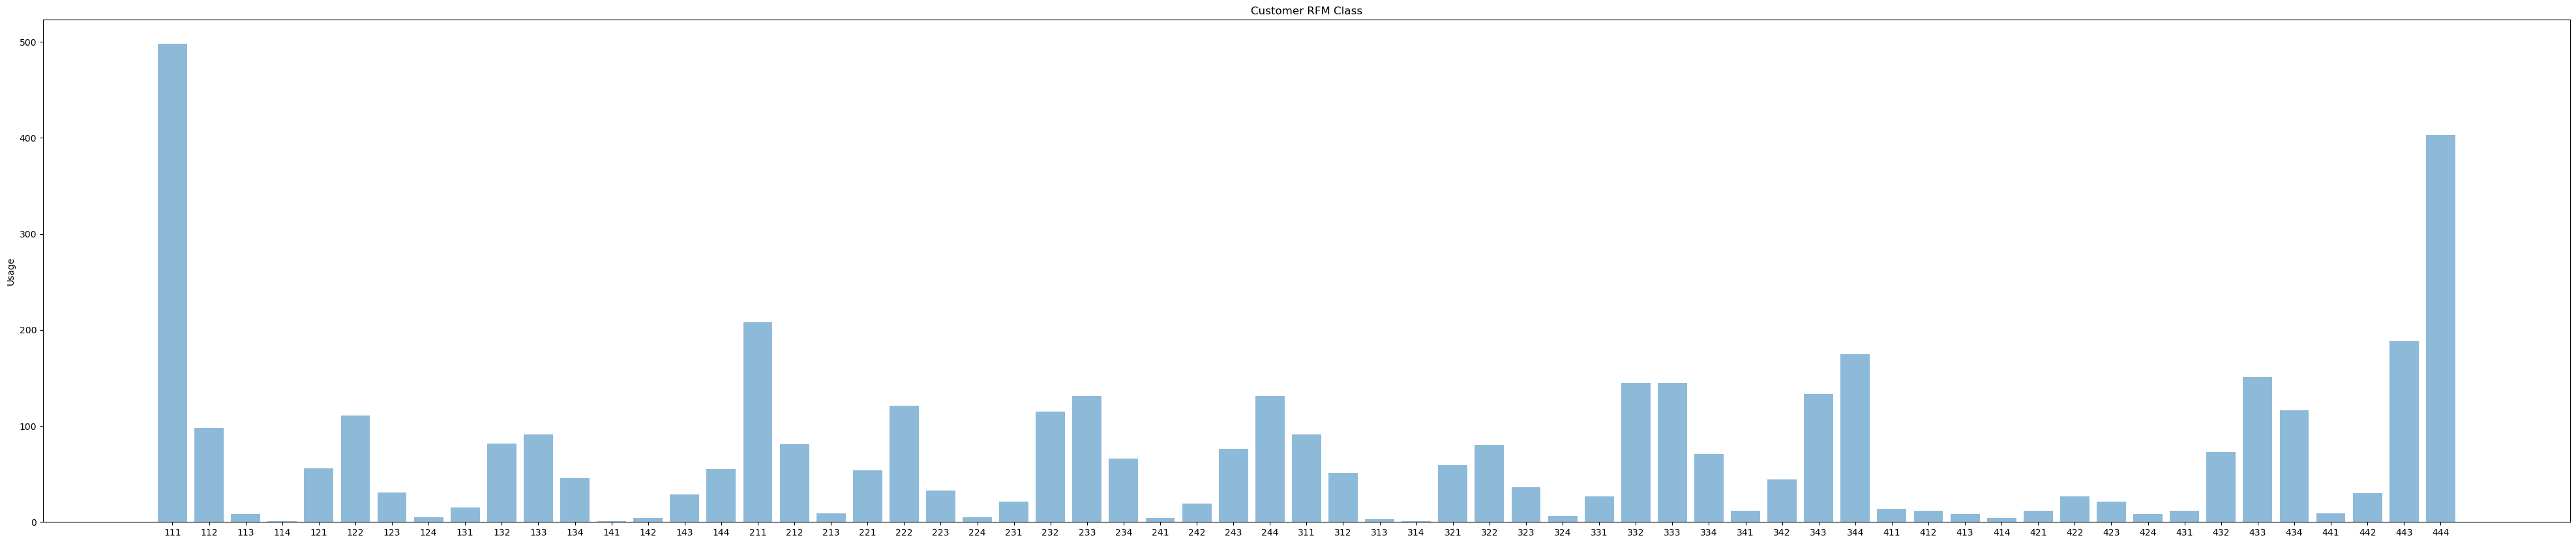

In [121]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(customerSegmentation['RFMClass'].index))
#print(y_pos)
performance = [10,8,6,4,2,1]
#print(np.arange(len(customerSegmentation['RFMClass'].index)))
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 50
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.bar(y_pos, customerSegmentation['ClassName'].values, align='center', alpha=0.5)
plt.xticks(y_pos, customerSegmentation['RFMClass'].index)
plt.ylabel('Usage')
plt.title('Customer RFM Class')

plt.show()

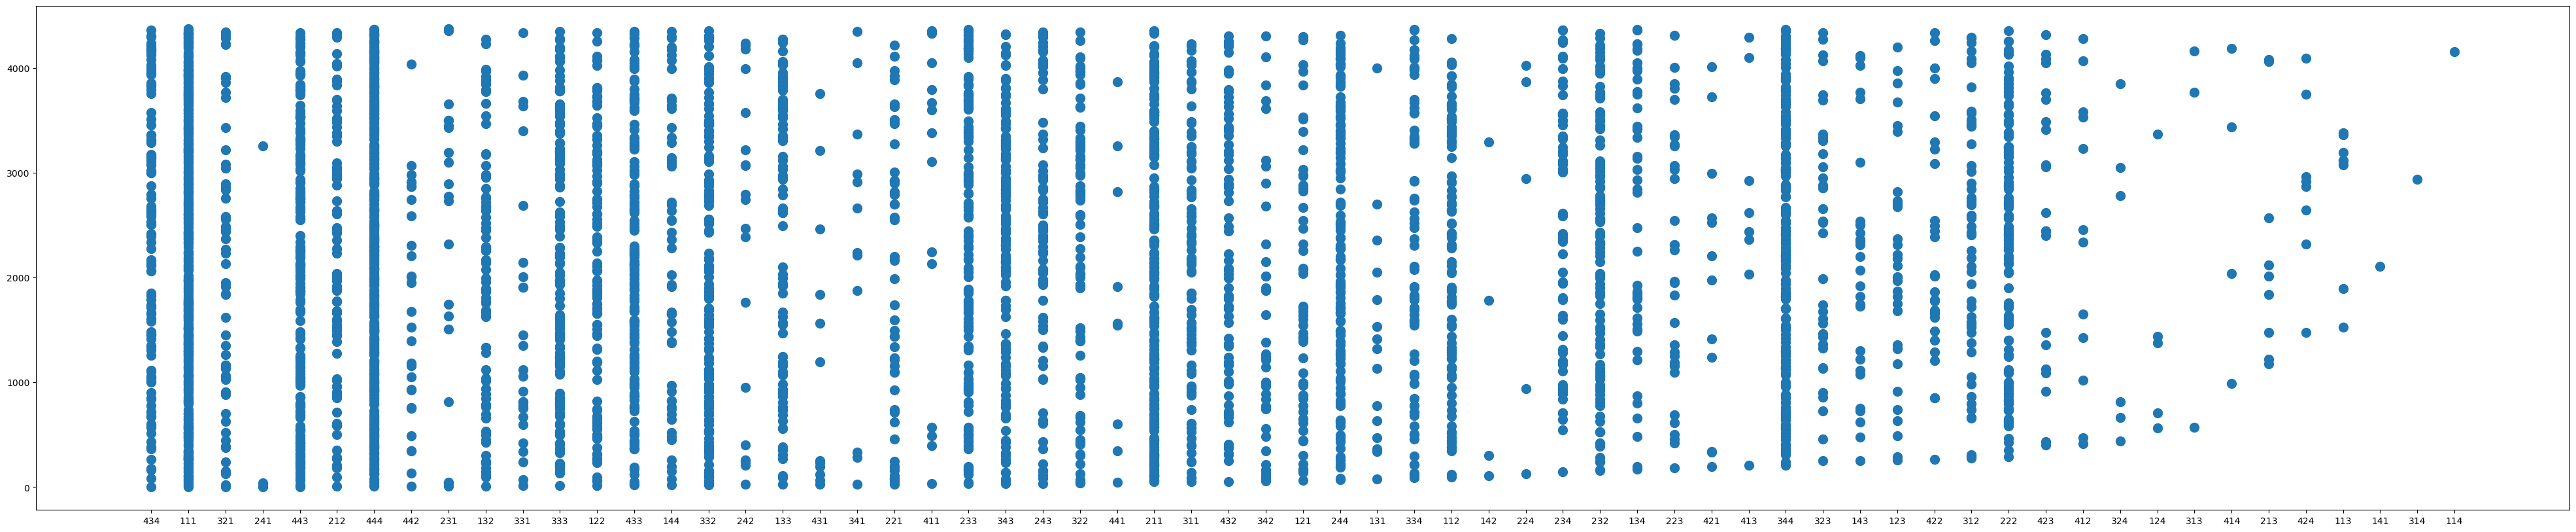

In [122]:
plt.scatter(rfmSegmentation['RFMClass'].values, rfmSegmentation['CustomerID'].values, s=100);

## machine learning

In [126]:
from sklearn.cluster import KMeans
import numpy as np
import csv

print(type(rfm))
print(rfm.columns)
print(rfm['recency'][0])
KMeanTable = [[]]
for i in range(len(rfm)):
    kMeanLine = []
    kMeanLine.append(rfm['recency'][i])
    kMeanLine.append(rfm['frequency'][i])
    KMeanTable.append(kMeanLine)

KMeanTable.pop(0)
print(KMeanTable[0])

kmeans = KMeans(n_clusters=7, random_state=0).fit(KMeanTable)
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)
line = [["Recency","monetary_value","frequency","RFMClass","CustomerName"]] 

for i in range(len(kmeans.labels_)):
    KMeanTable[i].append(kmeans.labels_[i])
    KMeanTable[i].append(rfm['CustomerID'][i])
    print(KMeanTable[i])
    line.append(KMeanTable[i])

with open('kmeans.csv', 'w',newline='',encoding="utf-8") as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in line:
        writer.writerow(row)

f.close()    

<class 'pandas.core.frame.DataFrame'>
Index(['CustomerID', 'recency', 'frequency', 'monetary', 'R_Quartile',
       'F_Quartile', 'M_Quartile', 'RFMClass'],
      dtype='object')
326.0
[326.0, 2]
[326.0, 2, 0, 0]
[2.0, 7, 4, 1]
[75.0, 4, 6, 2]
[19.0, 1, 4, 3]
[310.0, 1, 0, 4]
[36.0, 11, 1, 5]
[204.0, 1, 2, 6]
[232.0, 1, 5, 7]
[214.0, 1, 2, 8]
[23.0, 3, 1, 9]
[33.0, 1, 1, 10]
[2.0, 2, 4, 11]
[8.0, 6, 4, 12]
[52.0, 3, 1, 13]
[287.0, 1, 5, 14]
[3.0, 13, 4, 15]
[110.0, 2, 3, 16]
[8.0, 4, 4, 17]
[291.0, 3, 5, 18]
[4.0, 1, 4, 19]
[51.0, 4, 1, 20]
[45.0, 2, 1, 21]
[72.0, 3, 6, 22]
[311.0, 1, 0, 23]
[25.0, 1, 1, 24]
[3.0, 3, 4, 25]
[315.0, 2, 0, 26]
[130.0, 1, 3, 27]
[82.0, 3, 6, 28]
[22.0, 5, 4, 29]
[5.0, 6, 4, 30]
[185.0, 6, 2, 31]
[29.0, 3, 1, 32]
[338.0, 2, 0, 33]
[16.0, 6, 4, 34]
[80.0, 1, 6, 35]
[22.0, 1, 4, 36]
[72.0, 4, 6, 37]
[64.0, 2, 6, 38]
[16.0, 15, 4, 39]
[36.0, 2, 1, 40]
[46.0, 1, 1, 41]
[119.0, 4, 3, 42]
[303.0, 1, 0, 43]
[323.0, 1, 0, 44]
[50.0, 2, 1, 45]
[149.0, 1, 3, 46]
[22

In [128]:
from sklearn.cluster import KMeans
import numpy as np
import csv

print((rfm.values[0:3]))
kmeans = KMeans(n_clusters=7, random_state=0).fit(rfm.values)
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)

print(len(rfm))
line = [["Customer_id","monetary_value","frequency","recency","RFMClass"]]    
for i in range (len(kmeans.labels_)):
    #print(str(rfmTable.values[i][0])+ '->'+str(rfmTable.values[i][1]) +'->' + str(rfmTable.values[i][2])+'->'+ str(kmeans.labels_[i]))
    row = []
    row.append(rfm.values[i][7])
    row.append(rfm.values[i][0])
    row.append(rfm.values[i][1])
    row.append(rfm.values[i][2])
    row.append(kmeans.labels_[i])
    line.append(row)

with open('kmeans.csv', 'w',newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in line:
        writer.writerow(row)

f.close()

[[0 326.0 2 0.0 4 3 4 '434']
 [1 2.0 7 4309.999999999997 1 1 1 '111']
 [2 75.0 4 1797.24 3 2 1 '321']]
4372


In [151]:
print(rfm.columns)
AggloTable=[[]]
CustomerName = []
for i in range(len(rfm.values)):
    line = []
    line.append(rfm.values[i][0])
    line.append(rfm.values[i][1])
    line.append(rfm.values[i][2])
    CustomerName.append(rfm.values[i][7])
    AggloTable.append(line)
AggloTable.pop(0)
print(CustomerName[0])

Index(['CustomerID', 'recency', 'frequency', 'monetary', 'R_Quartile',
       'F_Quartile', 'M_Quartile', 'RFMClass'],
      dtype='object')
434


In [163]:
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)

print(len(rfm))
AgglomerateLine = [["Customer_id","monetary_value","frequency","recency","RFMClass"]]    
for i in range (len(kmeans.labels_)):
    row = []
    row.append(rfm.values[i][7])
    row.append(rfm.values[i][0])
    row.append(rfm.values[i][1])
    row.append(rfm.values[i][2])
    row.append(ResultAgglo.labels_[i])
    AgglomerateLine.append(row)

with open('Agglomerative.csv', 'w',newline='',encoding='utf-8') as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in AgglomerateLine:
        writer.writerow(row)

f.close()

4372


In [132]:
# DBSCAN(Density Based Spatial Clustering of Applications with Clustering) 

# ###############################
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=794, centers=centers, cluster_std=0.4,
                            random_state=0)
#print(AggloTable)
X = StandardScaler().fit_transform(AggloTable)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=12).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

[0 0 0 ... 0 0 0]
Estimated number of clusters: 1


ValueError: Found input variables with inconsistent numbers of samples: [794, 4372]

In [134]:
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)

print(len(rfm))
DBSCANLine = [["Customer_id","monetary_value","frequency","recency","RFMClass"]]    
for i in range (len(kmeans.labels_)):
    #print(str(rfmTable.values[i][0])+ '->'+str(rfmTable.values[i][1]) +'->' + str(rfmTable.values[i][2])+'->'+ str(kmeans.labels_[i]))
    row = []
    row.append(rfm.values[i][7])
    row.append(rfm.values[i][0])
    row.append(rfm.values[i][1])
    row.append(rfm.values[i][2])
    row.append(labels[i])
    DBSCANLine.append(row)

with open('DBSCAN.csv', 'w',newline='',encoding='utf-8') as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in DBSCANLine:
        writer.writerow(row)

f.close()

4372


## Client Description


In [140]:
## visualization
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4372 non-null   int64  
 1   recency     4372 non-null   float64
 2   frequency   4372 non-null   int64  
 3   monetary    4372 non-null   float64
 4   R_Quartile  4372 non-null   int64  
 5   F_Quartile  4372 non-null   int64  
 6   M_Quartile  4372 non-null   int64  
 7   RFMClass    4372 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 467.4+ KB


In [139]:
rfm.describe()

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,2185.500000,92.047118,5.075480,1898.459701,2.485819,2.650961,2.500000
std,1262.232018,100.765435,9.338754,8219.345141,1.124804,1.151264,1.118162
min,0.000000,1.000000,1.000000,-4287.630000,1.000000,1.000000,1.000000
25%,1092.750000,17.000000,1.000000,293.362500,1.000000,2.000000,1.750000
50%,2185.500000,50.000000,3.000000,648.075000,2.000000,3.000000,2.500000
75%,3278.250000,143.000000,5.000000,1611.725000,3.000000,4.000000,3.250000
max,4371.000000,374.000000,248.000000,279489.020000,4.000000,4.000000,4.000000


In [153]:
rfm['RFMClass'].unique()

array(['434', '111', '321', '241', '443', '212', '444', '442', '231',
       '132', '331', '333', '122', '433', '144', '332', '242', '133',
       '431', '341', '221', '411', '233', '343', '243', '322', '441',
       '211', '311', '432', '342', '121', '244', '131', '334', '112',
       '142', '224', '234', '232', '134', '223', '421', '413', '344',
       '323', '143', '123', '422', '312', '222', '423', '412', '324',
       '124', '313', '414', '213', '424', '113', '141', '314', '114'],
      dtype=object)

In [154]:
clients = rfm[['RFMClass','recency','frequency','monetary']].groupby('RFMClass').median()

In [155]:
clients.reset_index(inplace = True)

In [156]:
clients

,RFMClass,recency,frequency,monetary
0,111,5.0,13.0,3881.535
1,112,8.0,7.0,1269.760
2,113,7.0,6.5,536.570
3,114,12.0,8.0,191.170
4,121,8.0,5.0,2116.645
...,...,...,...,...
58,434,218.5,2.0,195.165
59,441,269.0,1.0,1837.920
60,442,257.5,1.0,885.045
61,443,261.5,1.0,370.000


Text(0.5, 1.0, 'Median Visit')

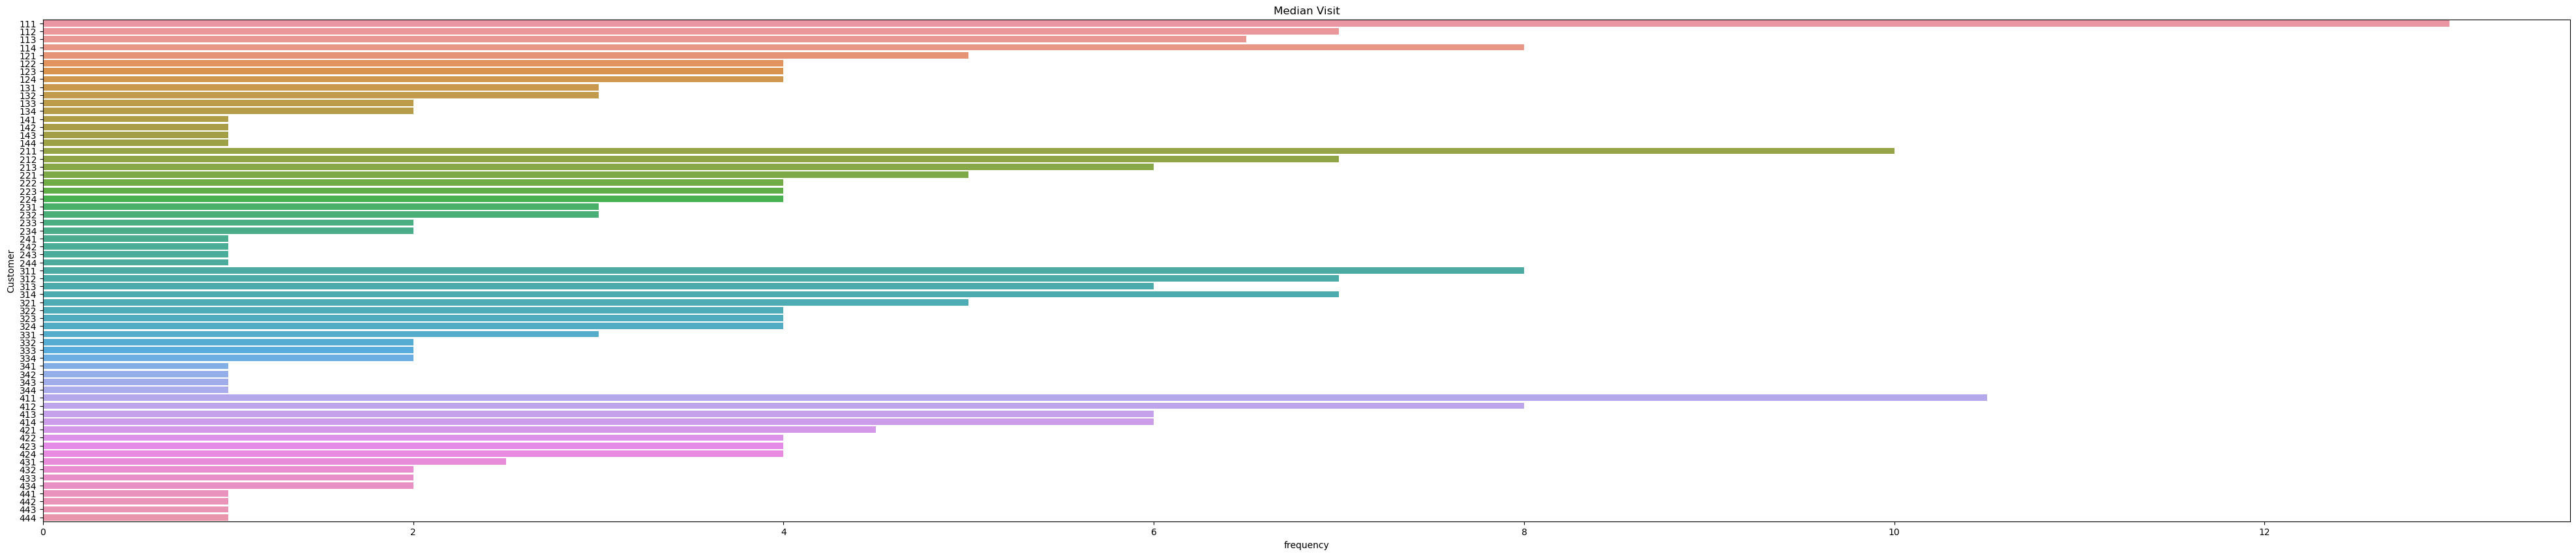

In [160]:
ax = sns.barplot(x = 'frequency', y = 'RFMClass', data = clients)
ax.set_ylabel('Customer')
ax.set_title('Median Visit')

Text(0.5, 1.0, 'Median Expenditure')

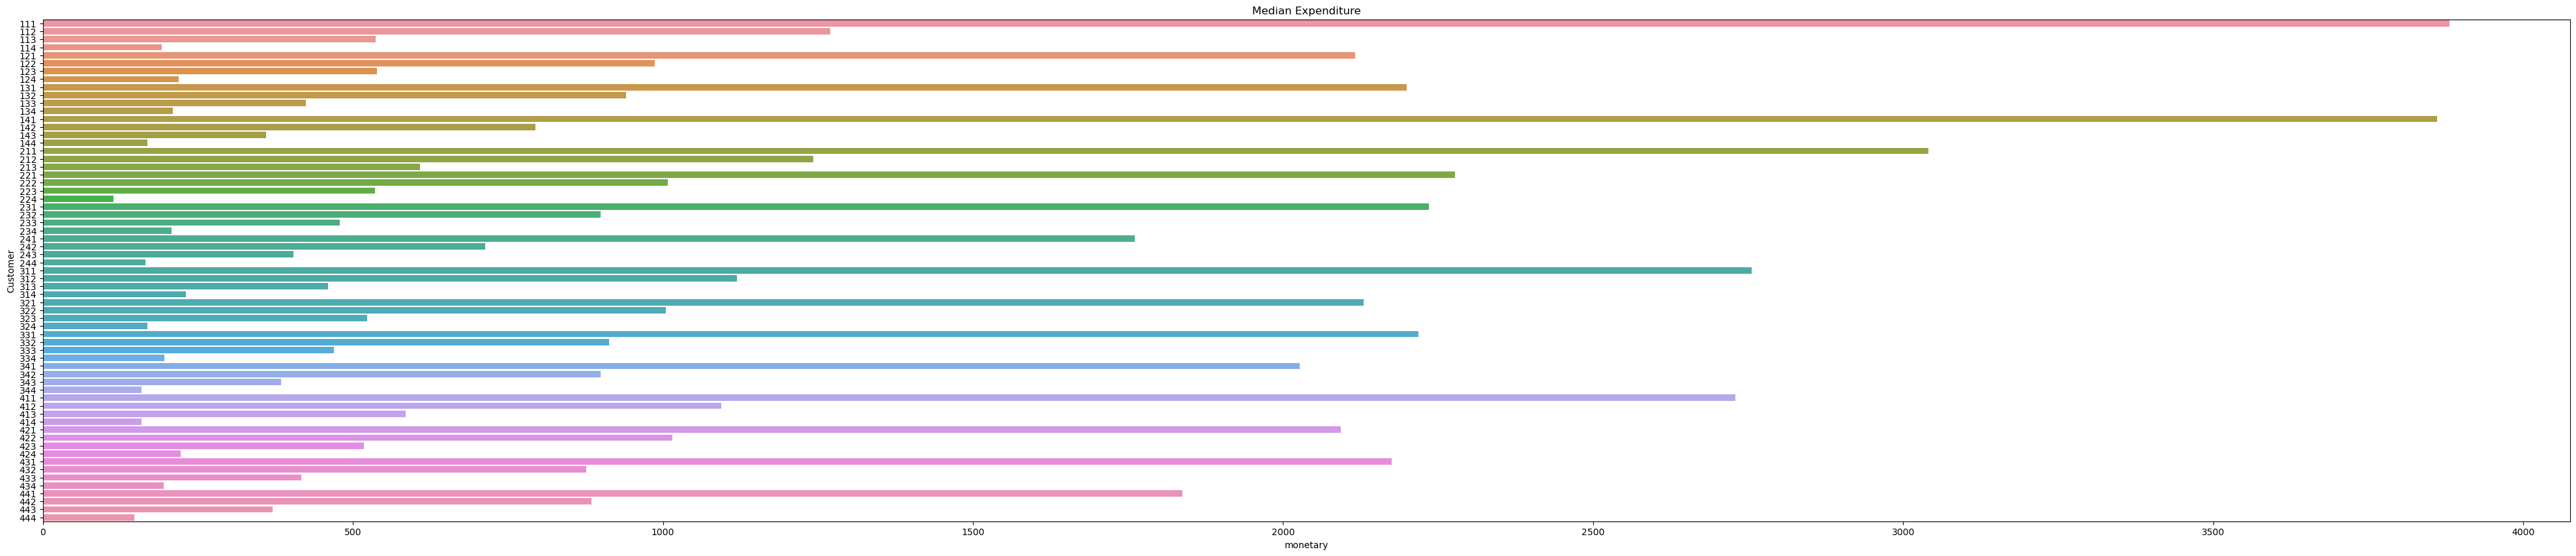

In [161]:
ax = sns.barplot(x = 'monetary', y = 'RFMClass', data = clients)
ax.set_ylabel('Customer')
ax.set_title('Median Expenditure')

Text(0.5, 1.0, 'Median Time from Last Shop')

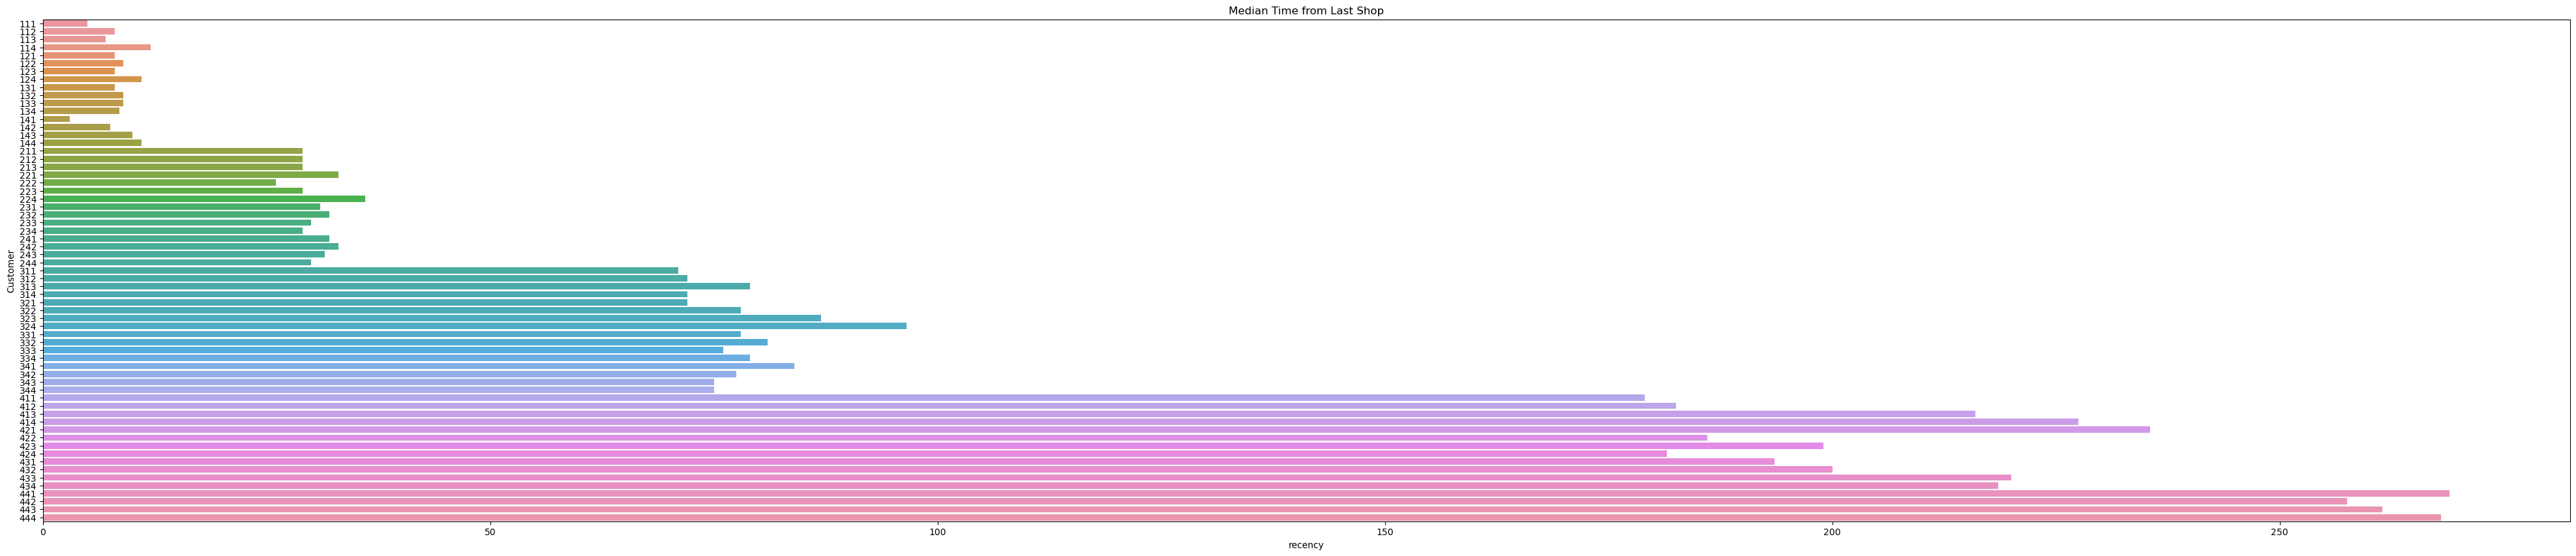

In [162]:
ax = sns.barplot(x = 'recency', y = 'RFMClass', data = clients)
ax.set_ylabel('Customer')
ax.set_title('Median Time from Last Shop')